# Reversible adiabatic descent tests

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '12'

import metpy.calc as mpcalc
from metpy.units import units
from metpy.units import concatenate
from metpy.plots import SkewT
import metpy.constants as const

import sys

sys.path.append('../scripts/')
from thermo import moist_lapse, reversible_lapse, saturation_specific_humidity
from thermo import wetbulb

## Theory from Saunders (1957)

**Saunders, P.M. (1957), *The thermodynamics of saturated air: a contribution to the classical theory*** states that along a reversible adiabat,
$$
(C_p + rC_w) \log T + \frac{r_w(p,T) L_v(T)}{T} - R \log p_a = A
$$
where
- $C_p$ is the specific heat of dry air at constant pressure,
- $r$ is the total mixing ratio of water (liquid and vapour) to dry air,
- $C_w$ is the specific heat of water (assumed constant w.r.t. temperature),
- $r_w(p,T)$ is the saturation mixing ratio,
- $L_v(T)$ is the latent heat of vapourisation of water,
- $R$ is the gas constant of dry air,
- $p_a$ is the partial pressure of dry air, and
- $A$ is a constant along the adiabat that can be determined from the initial conditions.

Substituting $p_a = p - e_s(T)$ where $e_s(T)$ is the saturation vapour pressure, we define
$$
f(T) = (C_p + rC_w) \log T + \frac{r_w(p,T) L_v(T)}{T} - R \log (p - e_s(T));
$$
we seek $T$ such that $f(T) = 0$. We can find
$$
f'(T) = \frac{C_p + rC_w}{T} + \frac{T \left(\frac{\partial r_w}{\partial T} L_v + r_w \frac{\mathrm{d}L_v}{\mathrm{d}T} \right) - r_w L_v}{T^2} + \frac{R \frac{\mathrm{d}e_s}{\mathrm{d}T}}{p - e_s}.
$$

If we use $L_v(T) = L_0 - L_1(T - C)$ where $L_0 = 2.501 \times 10^6$ J/kg, $L_1 = 2.37 \times 10^3$ J/kg/K and $C = 273.15$ K (Davies-Jones 2008), we have
$\mathrm{d}L_v/\mathrm{d}T = -L_1$.  
Bolton (1980) gives
$$ e_s(T) \approx e_0 \exp \left( \frac{a(T - C)}{T - C + b} \right) $$
where $e_0 = 6.112$ mbar, $a = 17.67$ and $b = 243.5$ K. It is easily found that
$$\frac{\mathrm{d}e_s}{\mathrm{d}T} = \frac{ab}{(T - C + b)^2} e_s. $$  
Finally, since
$$r_w(p,T) = \frac{\epsilon e_s(T)}{p - e_s(T)}$$
where $\epsilon$ is the molar mass ratio of water vapour to dry air, we can find that
$$ \frac{\partial r_w}{\partial T} = \frac{\epsilon p \frac{\mathrm{d}e_s}{\mathrm{d}T}}{(p - e_s)^2}. $$

In [40]:
def reversible_lapse_saunders(
        pressure, t_initial, l_initial, reference_pressure=None, improve=1):
    """
    Calculates temperature along reversible adiabats.
    
    Uses Eq. 3 of Saunders (1957).
    
    Args:
        pressure: Pressure array.
        t_initial: Initial temperature.
        l_initial: Initial ratio of liquid mass to total
        reference_pressure: Pressure corresponding to t_inital.
        improve: Number of Newton's method iterations to use.
        
    Returns:
        Resultant temperature array.
    """
    
    pressure = np.atleast_1d(pressure).m_as(units.mbar)
    if reference_pressure is None:
        reference_pressure = pressure[0]
    else:
        reference_pressure = reference_pressure.m_as(units.mbar)
        
    t_initial = t_initial.m_as(units.kelvin)
    if hasattr(l_initial, 'units'):
        l_initial = l_initial.m_as(units.dimensionless)
    
    # constants
    cp = const.dry_air_spec_heat_press.m
    cw = const.water_specific_heat.m*1e3
    R = const.dry_air_gas_constant.m
    C = 273.15
    e0 = 6.112
    a = 17.67
    b = 243.5
    epsilon = const.epsilon.m
    L0 = 2.501e6
    L1 = 2.37e3
    
    # total vapour + liquid water mixing ratio (invariant)
    q_initial = saturation_specific_humidity(
        reference_pressure*units.mbar, t_initial*units.kelvin).m
    r = (q_initial + l_initial)/(1 - q_initial - l_initial)
    
    def saunders_function(p, t):
        """Evaluates the LHS of Eq. 3 and its derivative w.r.t. temperature"""
        
        # saturation vapour pressure and derivative
        es = e0*np.exp(a*(t - C)/(t - C + b))
        des_dt = a*b/(t - C + b)**2 * es
        
        # saturation (vapour) mixing ratio and derivative
        rw = epsilon*es/(p - es)
        drw_dt = epsilon*p*des_dt/(p - es)**2
        
        # latent heat of vapourisation of water and derivative
        Lv = L0 - L1*(t - C)
        dLv_dt = -L1
        
        # LHS of Eq. 3 and derivative
        fvalue = (cp + r*cw)*np.log(t) + rw*Lv/t - R*np.log(p - es)
        fprime = ((cp + r*cw)/t + (t*(drw_dt*Lv + rw*dLv_dt) - rw*Lv)/t**2
                  + R*des_dt/(p - es))
        
        return fvalue, fprime
    
    # RHS of Eq. 3
    A, _ = saunders_function(reference_pressure, t_initial)
    
    # initial guess: pseudoadiabatic values
    t_final = moist_lapse(
        pressure*units.mbar, t_initial*units.kelvin,
        reference_pressure*units.mbar).m_as(units.kelvin)
    
    # apply Newton's method
    for i in range(improve):
        fvalue, fprime = saunders_function(pressure, t_final)
        t_final = t_final - (fvalue - A)/fprime
    
    return t_final*units.kelvin

## Testing: Ascent

In [41]:
pressure = np.arange(900, 499, -5)*units.mbar
t_initial = -5*units.celsius

In [75]:
t_pseudo = moist_lapse(pressure, t_initial)

t_reversible = reversible_lapse(
    pressure, t_initial, 1e-3, improve=2)

t_reversible_saunders1 = reversible_lapse_saunders(
    pressure, t_initial, 1e-3, improve=1)
t_reversible_saunders2 = reversible_lapse_saunders(
    pressure, t_initial, 1e-3, improve=2)
t_reversible_saunders3 = reversible_lapse_saunders(
    pressure, t_initial, 1e-3, improve=3)

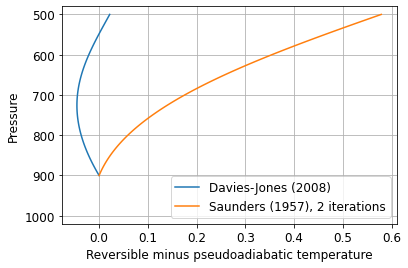

In [74]:
fig, ax = plt.subplots()
ax.plot(t_reversible - t_pseudo, pressure, label='Davies-Jones (2008)')
ax.plot(t_reversible_saunders2 - t_pseudo, pressure,
        label='Saunders (1957), 2 iterations')
ax.set_ylim(1020, 480)
ax.grid()
ax.set(
    xlabel='Reversible minus pseudoadiabatic temperature',
    ylabel='Pressure')
ax.legend(loc='lower right')

In [57]:
np.max(t_reversible_saunders1 - t_reversible_saunders3)

0.0003853410779299793 <Unit('kelvin')>

In [58]:
np.max(t_reversible_saunders2 - t_reversible_saunders3)

4.356195404398022e-10 <Unit('kelvin')>

## Testing: descent

In [84]:
pressure = np.arange(500, 1001, 10)*units.mbar
t_initial = -15*units.celsius

In [85]:
# initially saturated parcel
q_initial = saturation_specific_humidity(pressure[0], t_initial)
# values for moist descent only
t_max_final = moist_lapse(pressure[-1], t_initial, pressure[0])
q_max_final = saturation_specific_humidity(pressure[-1], t_max_final)
q_max_final - q_initial

0.009202454746105638 <Unit('dimensionless')>

In [86]:
t_pseudo = moist_lapse(pressure, t_initial)

t_reversible = reversible_lapse(
    pressure, t_initial, 10e-3, improve=2)

t_reversible_saunders1 = reversible_lapse_saunders(
    pressure, t_initial, 10e-3, improve=1)
t_reversible_saunders2 = reversible_lapse_saunders(
    pressure, t_initial, 10e-3, improve=2)
t_reversible_saunders3 = reversible_lapse_saunders(
    pressure, t_initial, 10e-3, improve=3)

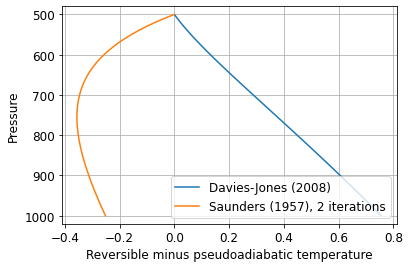

In [87]:
fig, ax = plt.subplots()
ax.plot(t_reversible - t_pseudo, pressure, label='Davies-Jones (2008)')
ax.plot(t_reversible_saunders2 - t_pseudo, pressure,
        label='Saunders (1957), 2 iterations')
ax.set_ylim(1020, 480)
ax.grid()
ax.set(
    xlabel='Reversible minus pseudoadiabatic temperature',
    ylabel='Pressure')
ax.legend(loc='lower right')

In [88]:
np.max(t_reversible_saunders1 - t_reversible_saunders3)

0.0019055109038959017 <Unit('kelvin')>

In [89]:
np.max(t_reversible_saunders2 - t_reversible_saunders3)

5.5023576805979246e-08 <Unit('kelvin')>